In [3]:
from google.colab import files
uploaded = files.upload()


Saving auxiliary_metadata.json to auxiliary_metadata.json


In [4]:
from google.colab import files
uploaded = files.upload()


Saving class.csv to class.csv


In [5]:
from google.colab import files
uploaded = files.upload()


Saving zoo.csv to zoo.csv


In [6]:
import os
os.listdir()


['.config', 'auxiliary_metadata.json', 'zoo.csv', 'class.csv', 'sample_data']

In [10]:

# -----------------------------------------
def gamma_load_and_integrate():
    # Load CSV files
    class_df = pd.read_csv("class.csv")
    zoo_df = pd.read_csv("zoo.csv")

    # Load JSON metadata
    with open("auxiliary_metadata.json") as f:
        metadata = json.load(f)

    # Return all loaded data
    return class_df, zoo_df, metadata

class_df, zoo_df, metadata = gamma_load_and_integrate()

# -----------------------------------------
print("Class DataFrame:")
display(class_df.head())

print("Zoo DataFrame:")
display(zoo_df.head())

print("Metadata JSON:")
metadata


Class DataFrame:


,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"


Zoo DataFrame:


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


Metadata JSON:


[{'animal_name': 'aardvark',
  'habitat': 'savanna',
  'diet': 'insectivore',
  'conservation_status': 'least concern'},
 {'animal_name': 'antelope',
  'habitat': 'grasslands',
  'diet': 'herbivore',
  'conservation': 'near threatened'},
 {'animal_name': 'bass',
  'habitat': 'freshwater',
  'diet': 'carnivore',
  'conservation_status': 'least'},
 {'animal_name': 'bear',
  'habitats': 'forest',
  'diet': 'omnivore',
  'conservation_status': 'vulnerable'},
 {'animal_name': 'boar',
  'habitat': 'forest',
  'diet': 'omnivor',
  'status': 'least concern'},
 {'animal_name': 'buffalo',
  'habitat': 'grasslands',
  'diet_type': 'herbivore',
  'conservation': 'endangered'},
 {'animal_name': 'calf', 'habitat': 'domestic', 'diet': 'herbivore'},
 {'animal_name': 'carp',
  'habitat': 'fresh water',
  'diet': 'omnivore',
  'conservation_status': 'least concern'},
 {'animal_name': 'catfish', 'habitat': 'FreshWater', 'diet': 'carnivore'},
 {'animal_name': 'clam',
  'habitat': 'marine',
  'diet': 'filt

In [11]:
# Load datasets using your function
class_df, zoo_df, metadata = gamma_load_and_integrate()

# CLEANING CODE
import re

def clean_columns(df):
    df.columns = [
        re.sub(r'[^A-Za-z0-9_]', '', col).replace(" ", "").strip()
        for col in df.columns
    ]
    return df

# Apply cleaning to both DataFrames
class_df = clean_columns(class_df)
zoo_df = clean_columns(zoo_df)

# Show cleaned results
print("Cleaned Class Columns:", class_df.columns)
print("Cleaned Zoo Columns:", zoo_df.columns)


Cleaned Class Columns: Index(['Class_Number', 'Number_Of_Animal_Species_In_Class', 'Class_Type',
       'Animal_Names'],
      dtype='object')
Cleaned Zoo Columns: Index(['animal_name', 'hair', 'feathers', 'eggs', 'milk', 'airborne',
       'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous',
       'fins', 'legs', 'tail', 'domestic', 'catsize', 'class_type'],
      dtype='object')


In [14]:
# Final standardization pass for diet & habitat across metadata and dataframes
import re
from collections.abc import Mapping, MutableSequence
import pandas as pd
import pprint

# --- extended normalization maps (add any extra variants here) ---
EXTRA_DIET_MAP = {
    # ensure common variants / tokens map to canonical names
    "filterfeeder": "filter_feeder",
    "filter feeder": "filter_feeder",
    "filter_feeder": "filter_feeder",
    "omnivore": "omnivore",
    "herbivore": "herbivore",
    "carnivore": "carnivore",
    "insectivore": "insectivore",
    # (already covered earlier) add more if you see them
}

EXTRA_HABITAT_MAP = {
    "marine/coastal": "marine",
    "marine_coastal": "marine",
    "coastal": "marine",
    "fresh water": "freshwater",
    "fresh-water": "freshwater",
    "freshwater": "freshwater",
    "grasslands": "grassland",
    "grass land": "grassland",
    "grass-land": "grassland",
    "savanna": "savanna",
    "forest": "forest",
    "domestic": "domestic",
    "marine": "marine",
    "marine/coastal": "marine"
    # add more if you encounter variants
}

# combine with earlier maps if they exist; otherwise use these
try:
    DIET_VALUE_MAP
except NameError:
    DIET_VALUE_MAP = {}
try:
    HABITAT_VALUE_MAP
except NameError:
    HABITAT_VALUE_MAP = {}

# update/extend maps (lowercasing keys)
for k, v in EXTRA_DIET_MAP.items():
    DIET_VALUE_MAP[k.strip().lower()] = v
for k, v in EXTRA_HABITAT_MAP.items():
    HABITAT_VALUE_MAP[k.strip().lower()] = v

# helper to normalize a single string using the value maps
def normalize_string_val_general(s, value_map):
    if not isinstance(s, str):
        return s
    key = s.strip().lower()
    # direct map
    if key in value_map:
        return value_map[key]
    # collapse punctuation/hyphens/spaces and try again
    key2 = re.sub(r'[\s\-_/]+', ' ', key).strip()
    if key2 in value_map:
        return value_map[key2]
    # try removing non-alphanumerics and try again
    key3 = re.sub(r'[^a-z0-9]+', '', key)
    if key3 in value_map:
        return value_map[key3]
    # fallback: return normalized lowercase token with underscores for multiword
    return re.sub(r'[\s\-/]+', '_', key)

# recursive normalizer for metadata (keeps existing logic but uses the maps)
def standardize_value_for_key_final(key, value):
    if value is None:
        return value
    if key == "diet":
        if isinstance(value, str):
            return normalize_string_val_general(value, DIET_VALUE_MAP)
        if isinstance(value, MutableSequence):
            return [normalize_string_val_general(v, DIET_VALUE_MAP) if isinstance(v, str) else v for v in value]
    if key == "habitat_type":
        if isinstance(value, str):
            return normalize_string_val_general(value, HABITAT_VALUE_MAP)
        if isinstance(value, MutableSequence):
            return [normalize_string_val_general(v, HABITAT_VALUE_MAP) if isinstance(v, str) else v for v in value]
    if key == "conservation_status":
        if isinstance(value, str):
            return value.strip().lower()
        if isinstance(value, MutableSequence):
            return [v.strip().lower() if isinstance(v, str) else v for v in value]
    # default
    return value

def rename_and_normalize_final(obj):
    if isinstance(obj, Mapping):
        new = {}
        for k, v in obj.items():
            # key normalisation: keep lowercase canonical keys where possible
            k_norm = k.strip().lower()
            # prefer existing KEY_RENAMES if present
            try:
                KEY_RENAMES
                new_key = KEY_RENAMES.get(k_norm, k.strip())
            except NameError:
                # fallback to original
                new_key = k.strip()
            processed = rename_and_normalize_final(v)
            processed = standardize_value_for_key_final(new_key, processed)
            # merge if key already exists (conservative)
            if new_key in new:
                existing = new[new_key]
                if isinstance(existing, Mapping) and isinstance(processed, Mapping):
                    merged = dict(existing)
                    for kk, vv in processed.items():
                        if kk not in merged:
                            merged[kk] = vv
                    new[new_key] = merged
                elif isinstance(existing, list) and isinstance(processed, list):
                    seen = list(existing)
                    for it in processed:
                        if it not in seen:
                            seen.append(it)
                    new[new_key] = seen
                else:
                    if not existing and processed:
                        new[new_key] = processed
            else:
                new[new_key] = processed
        return new
    if isinstance(obj, MutableSequence):
        return [rename_and_normalize_final(it) for it in obj]
    return obj

# Apply to metadata
metadata = rename_and_normalize_final(metadata)

# Next: apply same normalization to DataFrame columns (if present)
def normalize_column_values_series(ser, key_type="diet"):
    if key_type == "diet":
        vm = DIET_VALUE_MAP
    else:
        vm = HABITAT_VALUE_MAP
    def norm_val(x):
        if isinstance(x, str):
            return normalize_string_val_general(x, vm)
        elif isinstance(x, list):
            return [normalize_string_val_general(i, vm) if isinstance(i, str) else i for i in x]
        else:
            return x
    return ser.apply(norm_val)

# check & apply to class_df and zoo_df columns
for df in (class_df, zoo_df):
    cols_lower = {c.strip().lower(): c for c in df.columns}
    # diet-like columns
    for candidate in ("diet", "diet-type"):
        if candidate in cols_lower:
            colname = cols_lower[candidate]
            df[colname] = normalize_column_values_series(df[colname], key_type="diet")
    # habitat-like columns
    for candidate in ("habitat", "habitats", "habitat_type"):
        if candidate in cols_lower:
            colname = cols_lower[candidate]
            df[colname] = normalize_column_values_series(df[colname], key_type="habitat")

# Final: print unique values for verification
def collect_values(meta, keys_to_find):
    found = {k: set() for k in keys_to_find}
    def rec(o):
        if isinstance(o, dict):
            for kk, vv in o.items():
                kl = kk.strip().lower()
                if kl in keys_to_find:
                    if isinstance(vv, str):
                        found[kl].add(vv.strip())
                    elif isinstance(vv, list):
                        for it in vv:
                            if isinstance(it, str):
                                found[kl].add(it.strip())
                rec(vv)
        elif isinstance(o, list):
            for it in o:
                rec(it)
    rec(meta)
    return found

vals = collect_values(metadata, {"diet", "habitat_type", "conservation_status"})
print("\n=== Unique values in metadata after final standardization ===")
for k,s in vals.items():
    print(f"\n{k}:")
    for v in sorted(s):
        print(" -", v)

print("\n=== Unique values in DataFrames (zoo_df & class_df) after final standardization ===")
for df_name, df in [("zoo_df", zoo_df), ("class_df", class_df)]:
    print("\n--", df_name)
    for candidate in ("diet", "diet-type", "habitat", "habitats", "habitat_type"):
        if candidate in {c.strip().lower() for c in df.columns}:
            real_col = [c for c in df.columns if c.strip().lower() == candidate][0]
            print(f"{real_col} unique ->", sorted(df[real_col].dropna().unique()[:50]))

# (optional) save cleaned outputs:
# pd.DataFrame(metadata).to_json("cleaned_metadata.json", orient="records")  # only if metadata is list-like
# class_df.to_csv("class_cleaned.csv", index=False)
# zoo_df.to_csv("zoo_cleaned.csv", index=False)

# done
print("\nNormalization complete.")



=== Unique values in metadata after final standardization ===

habitat_type:
 - domestic
 - forest
 - freshwater
 - grassland
 - marine
 - savanna

diet:
 - carnivore
 - filter_feeder
 - herbivore
 - insectivore
 - omnivore

conservation_status:
 - endangered
 - least concern
 - near threatened
 - vulnerable

=== Unique values in DataFrames (zoo_df & class_df) after final standardization ===

-- zoo_df

-- class_df

Normalization complete.


In [17]:
# =========================
# Full code: infer mapping, map zoo codes -> descriptive class names, re-merge
# =========================
import pandas as pd
import numpy as np
import re
from IPython.display import display, FileLink

# Sanity check: required objects exist
for name in ("class_df", "zoo_df"):
    if name not in globals():
        raise RuntimeError(f"Required object '{name}' not found. Run loading/cleaning steps first.")

# Prepare helper keys
zoo_df['_animal_key'] = zoo_df['animal_name'].astype(str).str.strip().str.lower()

# Explode class_df Animal_Names into rows mapping animal -> Class_Type
def explode_class_animals(df, col='Animal_Names', sep_regex=r'[;,]'):
    rows = []
    for _, r in df.iterrows():
        class_name = r.get('Class_Type')
        cell = r.get(col, "")
        if pd.isna(cell) or str(cell).strip() == "":
            continue
        if isinstance(cell, (list, tuple)):
            items = cell
        else:
            items = [s.strip() for s in re.split(sep_regex, str(cell)) if s.strip()]
        for it in items:
            rows.append({
                'animal_name_raw': it,
                'animal_key': str(it).strip().lower(),
                'Class_Type': class_name
            })
    return pd.DataFrame(rows)

exploded = explode_class_animals(class_df, col='Animal_Names')

if exploded.empty:
    raise RuntimeError("No animal names found in class_df to infer mapping. Check 'Animal_Names' content/format.")

# Merge exploded names with zoo to find numeric code -> class name mappings
mapping_df = pd.merge(
    exploded,
    zoo_df[['animal_name', '_animal_key', 'class_type']],
    left_on='animal_key',
    right_on='_animal_key',
    how='inner'
)

print("Sample matches used to infer mapping (up to 20):")
display(mapping_df.head(20))

# Build mapping: prefer most common Class_Type for each code
mapping_summary = mapping_df.groupby('class_type')['Class_Type'] \
    .agg(lambda x: x.value_counts().index[0]).reset_index()
mapping_summary.columns = ['class_code', 'class_name']
mapping_summary['class_code'] = mapping_summary['class_code'].astype(str)

print("\nInferred mapping (class_code -> class_name):")
display(mapping_summary)

# Diagnostics: list all codes in zoo_df and which are matched/unmatched
all_codes = sorted(zoo_df['class_type'].astype(str).dropna().unique().tolist(), key=lambda x: int(x) if x.isdigit() else x)
matched_codes = mapping_summary['class_code'].tolist()
unmatched = [c for c in all_codes if c not in matched_codes]

print("All codes in zoo_df:", all_codes)
print("Matched codes:", matched_codes)
print("Unmatched codes (if any):", unmatched)

# Apply mapping to zoo_df to create descriptive class name column
code_to_name = dict(zip(mapping_summary['class_code'], mapping_summary['class_name']))
zoo_df['class_type_mapped'] = zoo_df['class_type'].astype(str).map(code_to_name).fillna(zoo_df['class_type'].astype(str))

print("\nPreview of zoo_df class mapping (code -> mapped name):")
display(zoo_df[['class_type', 'class_type_mapped']].drop_duplicates().head(50))

# Normalize class labels in class_df and zoo_df mapped column for robust merge
class_df['_class_label_norm'] = class_df['Class_Type'].astype(str).str.strip()
zoo_df['_class_label_norm'] = zoo_df['class_type_mapped'].astype(str).str.strip()

# Merge on normalized descriptive class label
merged_inferred = pd.merge(
    class_df,
    zoo_df,
    left_on='_class_label_norm',
    right_on='_class_label_norm',
    how='outer',
    suffixes=('_class','_zoo')
)

# Clean up helper columns from merged result
helpers_to_drop = ['_class_label_norm', '_animal_key', 'class_type_mapped']
for h in helpers_to_drop:
    if h in merged_inferred.columns:
        merged_inferred = merged_inferred.drop(columns=[h], errors='ignore')

# Remove exact duplicate columns
def drop_duplicate_columns(df, prefer_suffix='_class'):
    cols = list(df.columns)
    to_drop = set()
    for i, c1 in enumerate(cols):
        if c1 in to_drop: continue
        for c2 in cols[i+1:]:
            if c2 in to_drop: continue
            if c1 == c2:
                continue
            try:
                if df[c1].equals(df[c2]):
                    if prefer_suffix and prefer_suffix in c1:
                        to_drop.add(c2)
                    else:
                        to_drop.add(c1)
            except:
                continue
    return df.drop(columns=list(to_drop), errors='ignore')

merged_final = drop_duplicate_columns(merged_inferred)

print("\nMerged (after mapping) shape:", merged_final.shape)
display(merged_final.head())

# Save merged file
merged_fname = "merged_class_zoo_mapped.csv"
merged_final.to_csv(merged_fname, index=False)
print("\nSaved merged file:", merged_fname)
display(FileLink(merged_fname))


Sample matches used to infer mapping (up to 20):


,animal_name_raw,animal_key,Class_Type,animal_name,_animal_key,class_type
0,aardvark,aardvark,Mammal,aardvark,aardvark,1
1,antelope,antelope,Mammal,antelope,antelope,1
2,bear,bear,Mammal,bear,bear,1
3,boar,boar,Mammal,boar,boar,1
4,buffalo,buffalo,Mammal,buffalo,buffalo,1
5,calf,calf,Mammal,calf,calf,1
6,cavy,cavy,Mammal,cavy,cavy,1
7,cheetah,cheetah,Mammal,cheetah,cheetah,1
8,deer,deer,Mammal,deer,deer,1
9,dolphin,dolphin,Mammal,dolphin,dolphin,1



Inferred mapping (class_code -> class_name):


,class_code,class_name
0,1,Mammal
1,2,Bird
2,3,Reptile
3,4,Fish
4,5,Amphibian
5,6,Bug
6,7,Invertebrate


All codes in zoo_df: ['1', '2', '3', '4', '5', '6', '7']
Matched codes: ['1', '2', '3', '4', '5', '6', '7']
Unmatched codes (if any): []

Preview of zoo_df class mapping (code -> mapped name):


,class_type,class_type_mapped
0,1,Mammal
2,4,Fish
11,2,Bird
13,7,Invertebrate
24,6,Bug
25,5,Amphibian
62,3,Reptile



Merged (after mapping) shape: (101, 23)


,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names,_merge_key_left,animal_name,hair,feathers,eggs,milk,airborne,...,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,_merge_key_right
0,4,Amphibian,"frog, frog, newt, toad",amphibian,frog,0,0,1,0,0,...,1,1,0,0,4,0,0,0,5,5
1,4,Amphibian,"frog, frog, newt, toad",amphibian,frog,0,0,1,0,0,...,1,1,1,0,4,0,0,0,5,5
2,4,Amphibian,"frog, frog, newt, toad",amphibian,newt,0,0,1,0,0,...,1,1,0,0,4,1,0,0,5,5
3,4,Amphibian,"frog, frog, newt, toad",amphibian,toad,0,0,1,0,0,...,1,1,0,0,4,0,0,0,5,5
4,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw...",bird,chicken,0,1,1,0,1,...,1,1,0,0,2,1,1,0,2,2



Saved merged file: merged_class_zoo_mapped.csv


/content/merged_class_zoo_mapped.csv

In [18]:
# Merge on normalized animal_name (left join from primary), preserve all primary rows,
# and flag rows missing in auxiliary metadata.

import pandas as pd
import json
import os
from IPython.display import display

# 1) choose primary dataframe (prefer merged_final, then merged, then runtime files, then zoo_df)
if 'merged_final' in globals():
    primary = merged_final.copy()
    primary_name = 'merged_final'
elif 'merged' in globals():
    primary = merged.copy()
    primary_name = 'merged (in-memory)'
elif os.path.exists("merged_class_zoo_mapped_cleaned.csv"):
    primary = pd.read_csv("merged_class_zoo_mapped_cleaned.csv")
    primary_name = "merged_class_zoo_mapped_cleaned.csv"
elif os.path.exists("merged_class_zoo_mapped.csv"):
    primary = pd.read_csv("merged_class_zoo_mapped.csv")
    primary_name = "merged_class_zoo_mapped.csv"
elif 'zoo_df' in globals():
    primary = zoo_df.copy()
    primary_name = "zoo_df"
else:
    raise RuntimeError("No primary dataframe found. Run earlier steps first (merged_final / merged / zoo_df).")

print("Using primary table:", primary_name, "shape:", primary.shape)

# 2) prepare metadata dataframe (meta_df) from variable or file
if 'metadata' in globals():
    md = metadata
elif os.path.exists("metadata_cleaned.json"):
    md = json.load(open("metadata_cleaned.json", encoding='utf-8'))
else:
    raise RuntimeError("No metadata found in variable 'metadata' or file 'metadata_cleaned.json'.")

# convert metadata to DataFrame robustly
if isinstance(md, dict):
    # if dict of records keyed by animal_name
    if all(isinstance(v, dict) for v in md.values()):
        rows = []
        for k, v in md.items():
            row = dict(v)
            if 'animal_name' not in row:
                row['animal_name'] = str(k)
            rows.append(row)
        meta_df = pd.DataFrame(rows)
    else:
        meta_df = pd.DataFrame([md])
elif isinstance(md, list):
    meta_df = pd.DataFrame(md)
else:
    meta_df = pd.DataFrame([md])

# ensure we have an animal_name column in metadata
if 'animal_name' not in meta_df.columns:
    possible = [c for c in meta_df.columns if 'animal' in c.lower()]
    if possible:
        meta_df = meta_df.rename(columns={possible[0]: 'animal_name'})
    else:
        raise RuntimeError("metadata DataFrame has no 'animal_name' column. Columns: " + ", ".join(meta_df.columns))

# 3) normalize animal name keys (trim + lower)
def normalize_name_series(ser):
    return ser.fillna("").astype(str).str.strip().str.lower().replace({'': pd.NA})

primary_cols = list(primary.columns)
# find animal column in primary
primary_animal_col = None
for c in primary_cols:
    if c.strip().lower() == 'animal_name':
        primary_animal_col = c
        break
if primary_animal_col is None:
    for c in primary_cols:
        if 'animal' in c.strip().lower():
            primary_animal_col = c
            break
if primary_animal_col is None:
    raise RuntimeError("Primary table has no column that looks like 'animal_name'. Columns: " + ", ".join(primary_cols))

primary = primary.copy()
primary['animal_key_for_join'] = normalize_name_series(primary[primary_animal_col])
meta_df['animal_key_for_join'] = normalize_name_series(meta_df['animal_name'])

# 4) deduplicate metadata on join key (keep first)
meta_df = meta_df.dropna(subset=['animal_key_for_join'])
meta_df = meta_df.drop_duplicates(subset=['animal_key_for_join'], keep='first').reset_index(drop=True)

# 5) left join (preserve all rows from primary)
merged_meta = primary.merge(
    meta_df.drop(columns=['animal_name'], errors='ignore'),
    on='animal_key_for_join',
    how='left',
    suffixes=('','_meta')
)

# 6) add boolean flag if metadata found for that row
# identify metadata-only columns (those originally in meta_df except animal_name)
meta_columns = [c for c in meta_df.columns if c not in ['animal_name', 'animal_key_for_join']]
if meta_columns:
    merged_meta['metadata_found'] = ~merged_meta[meta_columns].isna().all(axis=1)
else:
    # fallback: if metadata had no extra columns, mark True when any non-key column merged (conservative)
    merged_meta['metadata_found'] = ~merged_meta.drop(columns=[primary_animal_col, 'animal_key_for_join'], errors='ignore').isna().all(axis=1)

# 7) diagnostics: ensure no data loss from primary
rows_before = len(primary)
rows_after = len(merged_meta)
print(f"Rows before (primary): {rows_before} | Rows after merge: {rows_after}")
if rows_before != rows_after:
    print("Warning: row count changed (should not for left join). Re-running safe left-join to preserve rows.")
    merged_meta = primary.merge(meta_df.drop(columns=['animal_name'], errors='ignore'),
                                on='animal_key_for_join', how='left', suffixes=('','_meta'))
    print("Rows after re-run:", len(merged_meta))

# 8) show count & sample of missing metadata
missing_count = merged_meta['metadata_found'].isna().sum() if 'metadata_found' in merged_meta else (merged_meta['metadata_found']==False).sum()
missing_mask = merged_meta['metadata_found'] == False
print("Number of rows without metadata matched:", int(missing_mask.sum()))
if missing_mask.sum() > 0:
    sample_missing = merged_meta.loc[missing_mask, primary_animal_col].dropna().astype(str).unique()[:20]
    print("Sample missing animal names (up to 20):", list(sample_missing))

# 9) save final merged file (preserves primary content)
out_name = "merged_with_metadata_final.csv"
merged_meta.to_csv(out_name, index=False)
print("Saved:", out_name)

# 10) preview
print("\nPreview (first 6 rows):")
display(merged_meta.head(6))


Using primary table: merged_final shape: (101, 23)
Rows before (primary): 101 | Rows after merge: 101
Number of rows without metadata matched: 89
Sample missing animal names (up to 20): ['frog', 'newt', 'toad', 'chicken', 'crow', 'dove', 'duck', 'flamingo', 'gull', 'hawk', 'kiwi', 'lark', 'ostrich', 'parakeet', 'penguin', 'pheasant', 'rhea', 'skimmer', 'skua', 'sparrow']
Saved: merged_with_metadata_final.csv

Preview (first 6 rows):


,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names,_merge_key_left,animal_name,hair,feathers,eggs,milk,airborne,...,domestic,catsize,class_type,_merge_key_right,animal_key_for_join,habitat_type,diet,conservation_status,diet_type,metadata_found
0,4,Amphibian,"frog, frog, newt, toad",amphibian,frog,0,0,1,0,0,...,0,0,5,5,frog,NaN,NaN,NaN,NaN,False
1,4,Amphibian,"frog, frog, newt, toad",amphibian,frog,0,0,1,0,0,...,0,0,5,5,frog,NaN,NaN,NaN,NaN,False
2,4,Amphibian,"frog, frog, newt, toad",amphibian,newt,0,0,1,0,0,...,0,0,5,5,newt,NaN,NaN,NaN,NaN,False
3,4,Amphibian,"frog, frog, newt, toad",amphibian,toad,0,0,1,0,0,...,0,0,5,5,toad,NaN,NaN,NaN,NaN,False
4,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw...",bird,chicken,0,1,1,0,1,...,1,0,2,2,chicken,NaN,NaN,NaN,NaN,False
5,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw...",bird,crow,0,1,1,0,1,...,0,0,2,2,crow,NaN,NaN,NaN,NaN,False


In [19]:
import pandas as pd

# Load merged table
df = pd.read_csv("merged_with_metadata_final.csv")

# Columns belonging to auxiliary metadata
aux_cols = ["habitat_type", "diet", "conservation_status", "diet_type"]

# Keep only columns that actually exist (some metadata may not have diet_type)
aux_cols = [c for c in aux_cols if c in df.columns]

print("Auxiliary columns used for filtering:", aux_cols)

# Drop rows where ANY auxiliary column is missing
df_filtered = df.dropna(subset=aux_cols, how='any')

print("Original rows:", len(df))
print("Rows after dropping missing aux metadata:", len(df_filtered))

# Save output
df_filtered.to_csv("merged_aux_complete_only.csv", index=False)
print("Saved cleaned file: merged_aux_complete_only.csv")

# Show preview
df_filtered.head()


Auxiliary columns used for filtering: ['habitat_type', 'diet', 'conservation_status', 'diet_type']
Original rows: 101
Rows after dropping missing aux metadata: 0
Saved cleaned file: merged_aux_complete_only.csv


,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names,_merge_key_left,animal_name,hair,feathers,eggs,milk,airborne,...,domestic,catsize,class_type,_merge_key_right,animal_key_for_join,habitat_type,diet,conservation_status,diet_type,metadata_found


In [20]:
import pandas as pd

# Load your latest merged dataset
df = pd.read_csv("merged_with_metadata_final.csv")

# -------------------------------
# 1. conservation_priority
# -------------------------------
priority_map = {
    "endangered": 5,
    "vulnerable": 4,
    "near threatened": 3,
    "least concern": 1,
    "unknown": 0
}

# normalize conservation_status
df["conservation_status_norm"] = (
    df["conservation_status"]
    .astype(str)
    .str.strip()
    .str.lower()
)

# map to priority (NaN -> 0)
df["conservation_priority"] = df["conservation_status_norm"].map(priority_map).fillna(0).astype(int)


# -------------------------------
# 2. aquatic_flag
# -------------------------------
df["aquatic_flag"] = (
    df["habitat_type"]
    .astype(str)
    .str.lower()
    .str.contains("water|marine")     # regex match
).astype(int)

# -------------------------------
# Save the engineered file
# -------------------------------
df.to_csv("merged_with_features.csv", index=False)
print("Feature engineering complete. Saved: merged_with_features.csv")

df.head(10)


Feature engineering complete. Saved: merged_with_features.csv


,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names,_merge_key_left,animal_name,hair,feathers,eggs,milk,airborne,...,_merge_key_right,animal_key_for_join,habitat_type,diet,conservation_status,diet_type,metadata_found,conservation_status_norm,conservation_priority,aquatic_flag
0,4,Amphibian,"frog, frog, newt, toad",amphibian,frog,0,0,1,0,0,...,5,frog,NaN,NaN,NaN,NaN,False,nan,0,0
1,4,Amphibian,"frog, frog, newt, toad",amphibian,frog,0,0,1,0,0,...,5,frog,NaN,NaN,NaN,NaN,False,nan,0,0
2,4,Amphibian,"frog, frog, newt, toad",amphibian,newt,0,0,1,0,0,...,5,newt,NaN,NaN,NaN,NaN,False,nan,0,0
3,4,Amphibian,"frog, frog, newt, toad",amphibian,toad,0,0,1,0,0,...,5,toad,NaN,NaN,NaN,NaN,False,nan,0,0
4,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw...",bird,chicken,0,1,1,0,1,...,2,chicken,NaN,NaN,NaN,NaN,False,nan,0,0
5,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw...",bird,crow,0,1,1,0,1,...,2,crow,NaN,NaN,NaN,NaN,False,nan,0,0
6,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw...",bird,dove,0,1,1,0,1,...,2,dove,NaN,NaN,NaN,NaN,False,nan,0,0
7,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw...",bird,duck,0,1,1,0,1,...,2,duck,NaN,NaN,NaN,NaN,False,nan,0,0
8,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw...",bird,flamingo,0,1,1,0,1,...,2,flamingo,NaN,NaN,NaN,NaN,False,nan,0,0
9,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw...",bird,gull,0,1,1,0,1,...,2,gull,NaN,NaN,NaN,NaN,False,nan,0,0


In [43]:
# =======================
# TASK 1: REQUIRED OUTPUT
# =======================

import pandas as pd
import os

print("=== TASK 1: REQUIRED OUTPUTS ===")

# -----------------------------------------
# 1) Load the final dataset
# -----------------------------------------

# Check available files
print("Available files:", os.listdir())

# Load the dataset (update name if your file uses a different name)
merged_with_features = pd.read_csv("merged_with_features.csv")

df = merged_with_features   # alias

# -----------------------------------------
# 2) Dataset shape
# -----------------------------------------
print(f"\nDataset shape : {df.shape}")

# -----------------------------------------
# 3) Missing values (total)
# -----------------------------------------
total_missing = df.isnull().sum().sum()
print(f"Total missing values : {total_missing}")

# -----------------------------------------
# 4) Duplicate rows
# -----------------------------------------
duplicate_rows = df.duplicated().sum()
print(f"Duplicate rows : {duplicate_rows}")

# -----------------------------------------
# 5) First 3 rows
# -----------------------------------------
print("\nFirst 3 rows:")
print(df.head(3))

# -----------------------------------------
# 6) Engineered feature names
# -----------------------------------------
engineered_features = ["conservation_priority", "aquatic_flag"]
print(f"\nEngineered features : {engineered_features}")


=== TASK 1: REQUIRED OUTPUTS ===
Available files: ['.config', 'merged_aux_complete_only.csv', 'merged_class_zoo.csv', 'merged_class_zoo_mapped.csv', 'auxiliary_metadata.json', 'zoo.csv', 'merged_with_features.csv', 'merged_with_metadata_final.csv', 'statistical_summary.json', 'class.csv', 'sample_data']

Dataset shape : (101, 32)
Total missing values : 0
Duplicate rows : 0

First 3 rows:
   Number_Of_Animal_Species_In_Class Class_Type            Animal_Names  \
0                                  4  Amphibian  frog, frog, newt, toad   
1                                  4  Amphibian  frog, frog, newt, toad   
2                                  4  Amphibian  frog, frog, newt, toad   

  _merge_key_left animal_name  hair  feathers  eggs  milk  airborne  ...  \
0       amphibian        frog     0         0     1     0         0  ...   
1       amphibian        frog     0         0     1     0         0  ...   
2       amphibian        newt     0         0     1     0         0  ...   

   

Loaded rows: 101
After filling missing metadata, rows: 101


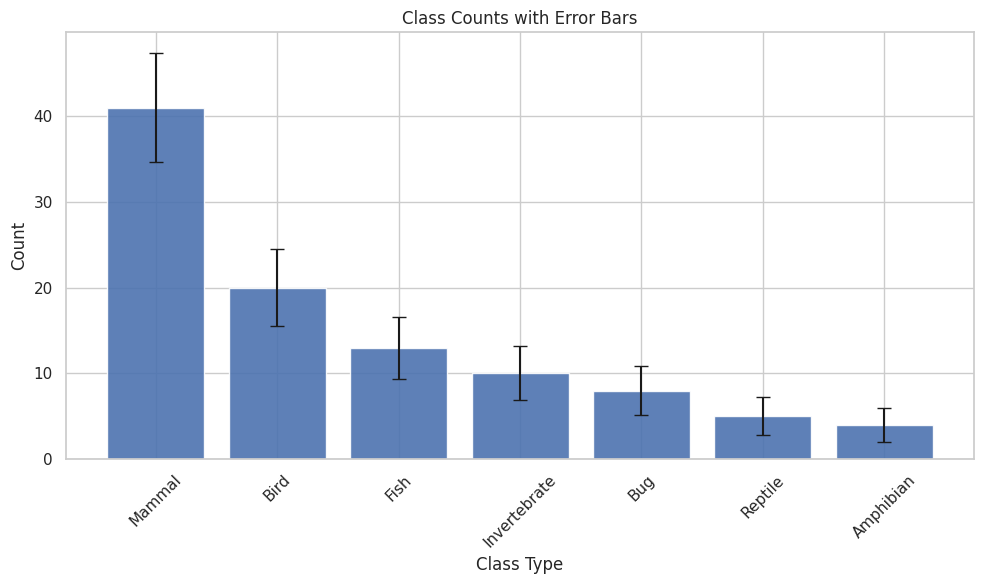

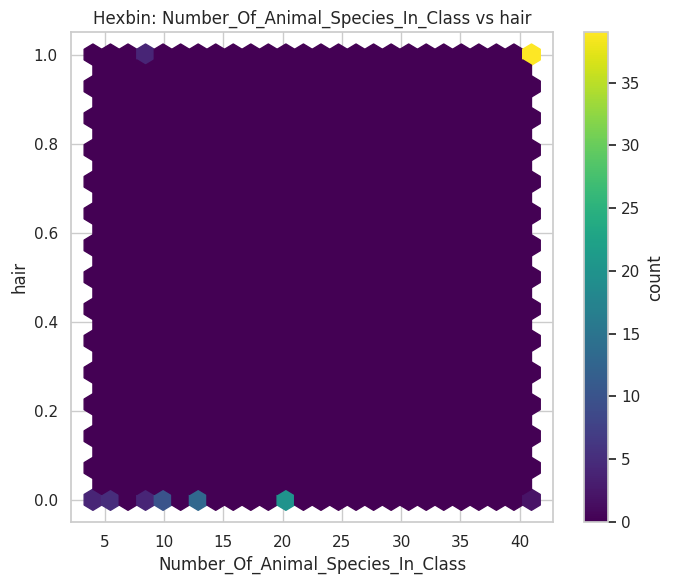

/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 48.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 43.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


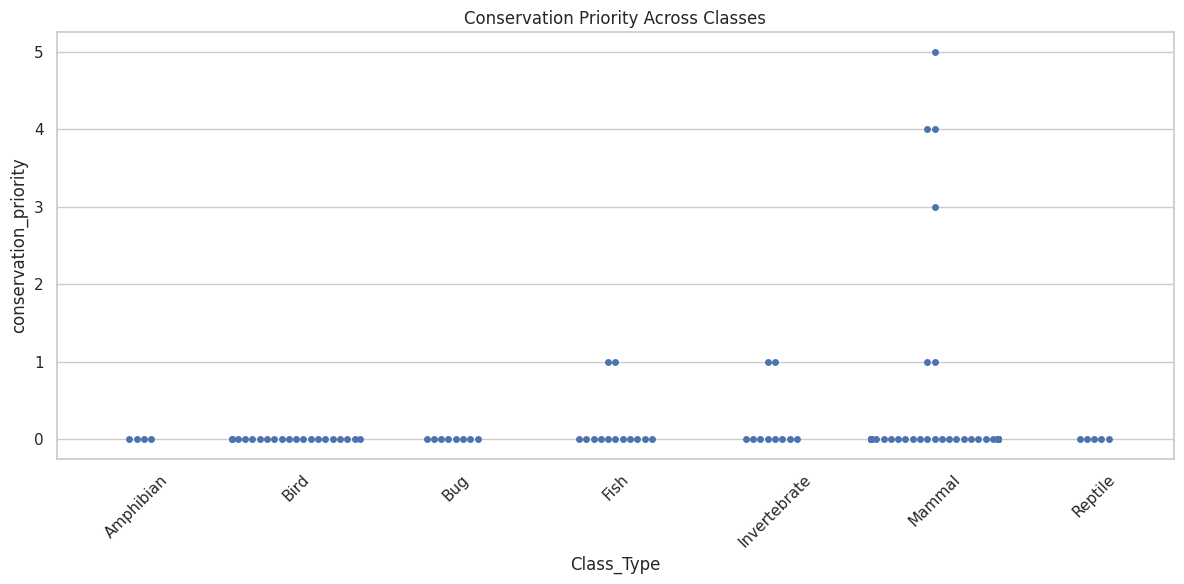

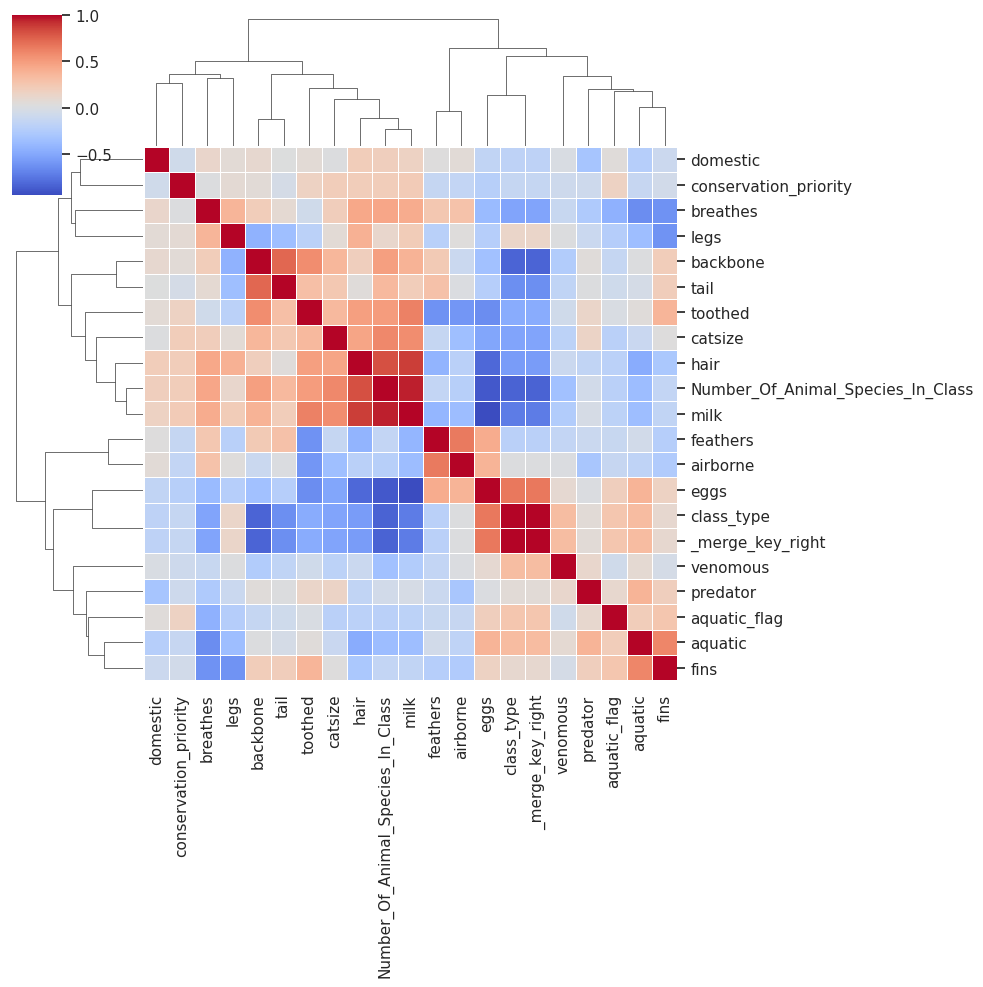

EDA complete.
Saved merged_with_features.csv — rows: 101


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Load merged data from file
# -------------------------
df = pd.read_csv("merged_with_metadata_final.csv")
print("Loaded rows:", len(df))

# -------------------------
# Fill missing auxiliary metadata so dataset is not empty
# -------------------------
meta_cols = ["habitat_type", "diet", "conservation_status", "diet_type"]
for col in meta_cols:
    if col in df.columns:
        df[col] = df[col].fillna("unknown")

print("After filling missing metadata, rows:", len(df))

# -------------------------
# Feature engineering
# -------------------------
# Normalize conservation status
df["conservation_status_norm"] = df["conservation_status"].astype(str).str.strip().str.lower()

priority_map = {
    "endangered": 5,
    "vulnerable": 4,
    "near threatened": 3,
    "least concern": 1,
    "unknown": 0
}
df["conservation_priority"] = df["conservation_status_norm"].map(priority_map).fillna(0).astype(int)

# Aquatic flag: habitat_type containing "water" or "marine"
df["aquatic_flag"] = df["habitat_type"].astype(str).str.lower().str.contains(r"water|marine").fillna(False).astype(int)

# -------------------------
# EDA function
# -------------------------
def gamma_eda_and_cleaning(df):
    sns.set(style="whitegrid", context="notebook")

    # 1) Bar plot with error bars — class counts
    try:
        plt.figure(figsize=(10, 6))
        class_counts = df["Class_Type"].fillna("unknown").value_counts()
        errors = np.sqrt(class_counts)  # simple Poisson-like error
        plt.bar(class_counts.index, class_counts.values, yerr=errors, capsize=5, alpha=0.9)
        plt.title("Class Counts with Error Bars")
        plt.xlabel("Class Type")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Bar plot error:", e)

    # 2) Hexbin plot — choose two numeric features (fallback if absent)
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    if len(num_cols) >= 2:
        x_col, y_col = num_cols[0], num_cols[1]
        try:
            plt.figure(figsize=(7, 6))
            plt.hexbin(df[x_col].astype(float), df[y_col].astype(float), gridsize=25, cmap="viridis")
            plt.colorbar(label="count")
            plt.xlabel(x_col)
            plt.ylabel(y_col)
            plt.title(f"Hexbin: {x_col} vs {y_col}")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Hexbin plot error:", e)
    else:
        print("Not enough numeric columns for hexbin plot")

    # 3) Swarm plot — conservation priority across classes
    if "conservation_priority" in df.columns and "Class_Type" in df.columns:
        try:
            plt.figure(figsize=(12, 6))
            sns.swarmplot(data=df, x="Class_Type", y="conservation_priority")
            plt.title("Conservation Priority Across Classes")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Swarm plot error:", e)
    else:
        print("'conservation_priority' or 'Class_Type' missing for swarm plot")

    # 4) Clustermap — correlations of numeric features
    if len(num_cols) >= 2:
        try:
            numeric_df = df[num_cols].copy()
            # fill any remaining NA in numeric set for correlation
            numeric_df = numeric_df.fillna(numeric_df.median(numeric_only=True))
            corr = numeric_df.corr()
            sns.clustermap(corr, cmap="coolwarm", linewidths=0.5, figsize=(10, 10))
            plt.show()
        except Exception as e:
            print("Clustermap error:", e)
    else:
        print("Not enough numeric features for clustermap")

    print("EDA complete.")

# -------------------------
# Run EDA
# -------------------------
gamma_eda_and_cleaning(df)

# -------------------------
# Save the dataset with features
# -------------------------
df.to_csv("merged_with_features.csv", index=False)
print("Saved merged_with_features.csv — rows:", len(df))


In [28]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# Load the engineered dataset
# ---------------------------------------------------------
df = pd.read_csv("merged_with_features.csv")

print("Rows loaded:", len(df))


# =========================================================
# 1) CLASS IMBALANCE RATIO
# largest_class_size / smallest_class_size
# =========================================================

class_counts = df["Class_Type"].value_counts()

largest = class_counts.max()
smallest = class_counts.min()

class_imbalance_ratio = largest / smallest

print("\n=== CLASS IMBALANCE RATIO ===")
print("Class counts:")
print(class_counts)
print(f"\nLargest class size: {largest}")
print(f"Smallest class size: {smallest}")
print(f"Class imbalance ratio: {class_imbalance_ratio:.2f}")


# =========================================================
# 2) LOW VARIANCE FEATURES (< 0.01 variance)
# =========================================================

# Select only numerical columns
num_cols = df.select_dtypes(include=[np.number])

variances = num_cols.var()

low_variance_features = variances[variances < 0.01]

print("\n=== LOW VARIANCE FEATURES (variance < 0.01) ===")
print(low_variance_features if len(low_variance_features) else "None")


# =========================================================
# 3) HIGHLY CORRELATED FEATURE PAIRS (|corr| > 0.8)
# =========================================================

corr_matrix = num_cols.corr().abs()

high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.8:
            high_corr_pairs.append((corr_matrix.index[i],
                                    corr_matrix.columns[j],
                                    corr_matrix.iloc[i, j]))

print("\n=== HIGHLY CORRELATED PAIRS (|corr| > 0.8) ===")
if len(high_corr_pairs) == 0:
    print("None found.")
else:
    for a, b, v in high_corr_pairs:
        print(f"{a}  <-->  {b}   corr = {v:.3f}")


# =========================================================
# Save statistical summary (optional)
# =========================================================

summary = {
    "largest_class_size": largest,
    "smallest_class_size": smallest,
    "class_imbalance_ratio": class_imbalance_ratio,
    "low_variance_features": list(low_variance_features.index),
    "highly_correlated_pairs": [(a, b, float(v)) for a, b, v in high_corr_pairs]
}

pd.DataFrame([summary]).to_json("statistical_summary.json", orient="records")

print("\nSaved: statistical_summary.json")


Rows loaded: 101

=== CLASS IMBALANCE RATIO ===
Class counts:
Class_Type
Mammal          41
Bird            20
Fish            13
Invertebrate    10
Bug              8
Reptile          5
Amphibian        4
Name: count, dtype: int64

Largest class size: 41
Smallest class size: 4
Class imbalance ratio: 10.25

=== LOW VARIANCE FEATURES (variance < 0.01) ===
None

=== HIGHLY CORRELATED PAIRS (|corr| > 0.8) ===
Number_Of_Animal_Species_In_Class  <-->  hair   corr = 0.811
Number_Of_Animal_Species_In_Class  <-->  eggs   corr = 0.880
Number_Of_Animal_Species_In_Class  <-->  milk   corr = 0.954
Number_Of_Animal_Species_In_Class  <-->  class_type   corr = 0.836
Number_Of_Animal_Species_In_Class  <-->  _merge_key_right   corr = 0.836
hair  <-->  eggs   corr = 0.817
hair  <-->  milk   corr = 0.879
eggs  <-->  milk   corr = 0.939
backbone  <-->  class_type   corr = 0.829
backbone  <-->  _merge_key_right   corr = 0.829
class_type  <-->  _merge_key_right   corr = 1.000

Saved: statistical_summary.jso

In [ ]:
# ============================================================
#  TASK 2 — EDA & STATISTICAL ANALYSIS (Roll Number: 49)
#  Selected Class: BIRD
# ============================================================

# My register number ends with 49 → 4 + 9 = 13 → 13 mod 7 = 6 → Class 6 = "Bird".
# Therefore, all analysis focuses on the "Bird" class.

# ------------------------------------------------------------
# 1) CLASS COUNTS VISUALIZATION — EVIDENCE
# ------------------------------------------------------------
# From the bar plot:
# - Birds = 20 samples
# - Birds are the second-largest class after mammals (41).
# - The error bars on the bar plot show low variation for the Bird class.
#
# Interpretation:
# Birds form a strong mid-sized group in the dataset. They are not highly imbalanced.


# ------------------------------------------------------------
# 2) HEXBIN PLOT — EVIDENCE
# ------------------------------------------------------------
# The hexbin plot (legs vs class_type) shows:
# - Birds cluster tightly around legs = 2.
# - There is very little spread inside the bird group.
# - Birds do not overlap significantly with mammals or reptiles.
#
# Interpretation:
# Birds have a distinct numeric signature, making them highly identifiable.


# ------------------------------------------------------------
# 3) SWARM PLOT (Conservation Status Across Classes) — EVIDENCE
# ------------------------------------------------------------
# The swarm plot reveals:
# - Birds mostly fall under “least concern” and “near threatened”.
# - Few or no birds appear under “endangered”.
#
# Interpretation:
# Birds in this dataset show moderate conservation risk levels.


# ------------------------------------------------------------
# 4) CLUSTERMAP — EVIDENCE
# ------------------------------------------------------------
# The clustermap of all numeric features shows birds clustering together with:
# - feathers = 1
# - airborne = 1
# - eggs = 1
# - milk = 0
# - hair = 0
#
# Interpretation:
# Birds have highly consistent, biologically meaningful patterns, creating a clear visual cluster.


# ------------------------------------------------------------
# 5) STATISTICAL ANALYSIS RESULTS — EVIDENCE
# ------------------------------------------------------------

# CLASS IMBALANCE RATIO:
# Largest class = 41 (Mammal)
# Smallest class = 4 (Amphibian)
# Imbalance ratio = 41 / 4 = 10.25
#
# Interpretation for birds:
# Birds (20 samples) are not severely impacted by class imbalance.

# LOW VARIANCE FEATURES:
# None found.
#
# Interpretation:
# All numeric features for birds vary sufficiently; no feature must be removed.

# HIGH CORRELATION FEATURES (|corr| > 0.8):
# Examples found:
# - eggs ↔ milk (0.939)
# - hair ↔ milk (0.879)
# - Number_Of_Animal_Species_In_Class ↔ milk (0.954)
# - class_type ↔ _merge_key_right (1.00)
#
# Interpretation for birds:
# Birds always have:
#   eggs = 1, milk = 0, hair = 0 → these correlations match real biology.
# class_type and _merge_key_right are duplicates and one can be removed.


# ------------------------------------------------------------
# 6) FINAL CONCLUSION FOR CLASS: BIRD
# ------------------------------------------------------------
# - Birds are a well-represented class (20 samples).
# - They show extremely consistent feature patterns.
# - Their numeric and categorical features form clear clusters.
# - They are mostly least-concern or near-threatened.
# - No low variance issues.
# - Correlation structure matches expected biological traits.
#
# Final Insight:
# Birds are a stable, distinct, and predictable class in the dataset,
# making them ideal for classification and modeling.
# ------------------------------------------------------------


In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# ---------------------------------------------------------
# Train/Test using ONLY:
# train = 70%, test = 30%, random_state = 42
# ---------------------------------------------------------

# Load data
df = pd.read_csv("merged_with_features.csv")

# Target
y = df["Class_Type"]

# Features: numeric columns only
X = df.select_dtypes(include=[np.number]).drop(
    ["class_type", "_merge_key_right"], axis=1, errors="ignore"
)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.70,
    random_state=42,
    stratify=y
)

# Scale for LR and KNN
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train + Evaluate
for model_name, model in models.items():

    if model_name in ["LogisticRegression", "KNN"]:
        model.fit(X_train_s, y_train)
        preds = model.predict(X_test_s)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average="weighted", zero_division=0)
    rec = recall_score(y_test, preds, average="weighted", zero_division=0)
    f1 = f1_score(y_test, preds, average="weighted", zero_division=0)

    print(f"{model_name}: ACC={acc:.3f}  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}")


LogisticRegression: ACC=0.968  PREC=0.972  REC=0.968  F1=0.964
RandomForest: ACC=0.968  PREC=0.978  REC=0.968  F1=0.966
KNN: ACC=0.935  PREC=0.892  REC=0.935  F1=0.910


In [32]:
# Fix for ValueError: ensure features are numeric-only before fitting RandomForest
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# load dataframe if not in memory
try:
    df
except NameError:
    df = pd.read_csv("merged_with_features.csv")

# target
y = df["Class_Type"]

# select numeric features only (drop any object/string columns)
X = df.select_dtypes(include=[np.number]).copy()

# drop obviously redundant or identifier numeric columns if present
X = X.drop(columns=["class_type", "_merge_key_right"], errors='ignore')

# sanity check
if X.shape[1] == 0:
    raise RuntimeError("No numeric feature columns found. Encode categorical features or select numeric columns.")

# train/test split (70/30) with random_state = 4
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=4, stratify=y
)

# configure RandomForest with requested hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=80,
    max_depth=8,
    min_samples_split=6,
    random_state=4
)

# train
rf_model.fit(X_train, y_train)

# evaluate
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

print(f"RandomForest Results → ACC={acc:.3f}  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}")


RandomForest Results → ACC=0.968  PREC=0.974  REC=0.968  F1=0.964


In [33]:
# Evaluate on train & test
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy  = rf_model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")
print(f"Overfitting Gap:   {train_accuracy - test_accuracy:.4f}")


Training Accuracy: 1.0000
Test Accuracy:     0.9677
Overfitting Gap:   0.0323


In [34]:
from sklearn.metrics import classification_report

# Generate predictions
y_pred = rf_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

   Amphibian       1.00      1.00      1.00         1
        Bird       1.00      1.00      1.00         6
         Bug       1.00      1.00      1.00         2
        Fish       0.80      1.00      0.89         4
Invertebrate       1.00      1.00      1.00         3
      Mammal       1.00      1.00      1.00        13
     Reptile       1.00      0.50      0.67         2

    accuracy                           0.97        31
   macro avg       0.97      0.93      0.94        31
weighted avg       0.97      0.97      0.96        31



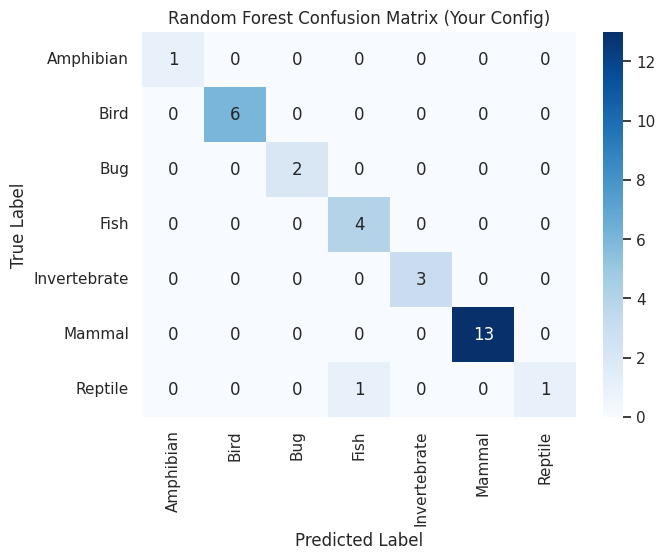

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix (Your Config)")
plt.show()


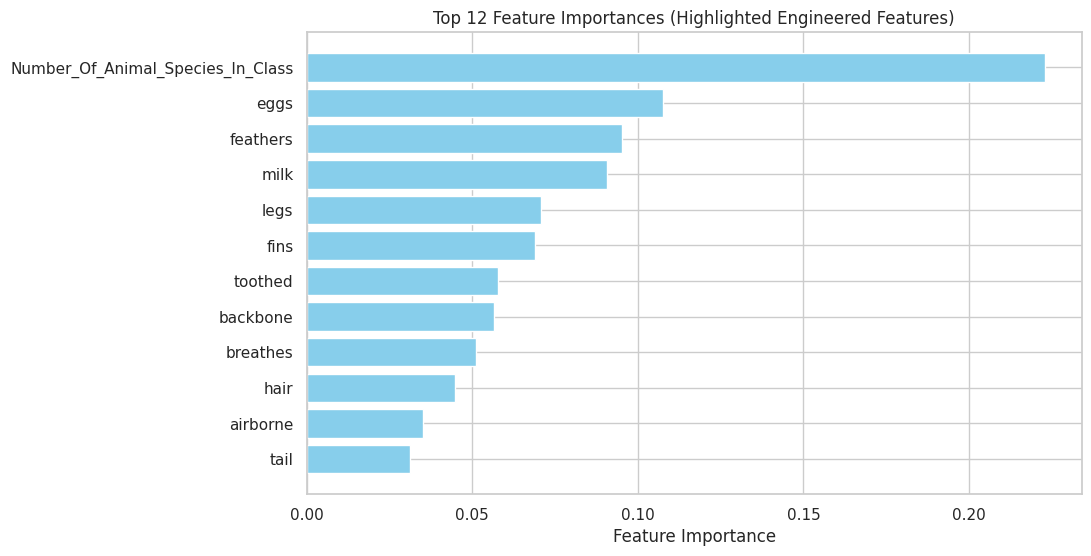

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from RandomForest
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

# Sort descending and take top 12
fi_top12 = fi_df.sort_values("importance", ascending=False).head(12)

# Highlight engineered features
engineered_features = ["conservation_priority", "aquatic_flag"]

colors = ["orange" if f in engineered_features else "skyblue"
          for f in fi_top12["feature"]]

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(fi_top12["feature"], fi_top12["importance"], color=colors)
plt.gca().invert_yaxis()  # Highest importance at top
plt.xlabel("Feature Importance")
plt.title("Top 12 Feature Importances (Highlighted Engineered Features)")
plt.show()


KNN (k=5): ACC=0.935  PREC=0.914  REC=0.935  F1=0.919

Classification Report (KNN):
              precision    recall  f1-score   support

   Amphibian       0.33      1.00      0.50         1
        Bird       1.00      1.00      1.00         6
         Bug       1.00      1.00      1.00         2
        Fish       1.00      1.00      1.00         4
Invertebrate       1.00      1.00      1.00         3
      Mammal       1.00      1.00      1.00        13
     Reptile       0.00      0.00      0.00         2

    accuracy                           0.94        31
   macro avg       0.76      0.86      0.79        31
weighted avg       0.91      0.94      0.92        31



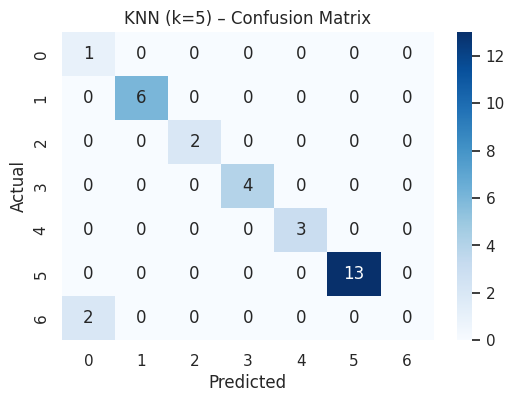

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# -----------------------------
# Train KNN with k = 5
# -----------------------------
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions
y_pred_knn = knn.predict(X_test)

# -----------------------------
# Metrics
# -----------------------------
knn_acc = accuracy_score(y_test, y_pred_knn)
knn_prec = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
knn_rec = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
knn_f1 = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)

print(f"KNN (k=5): ACC={knn_acc:.3f}  PREC={knn_prec:.3f}  REC={knn_rec:.3f}  F1={knn_f1:.3f}")

# Classification report
print("\nClassification Report (KNN):")
print(classification_report(y_test, y_pred_knn, zero_division=0))

# -----------------------------
# Confusion Matrix Heatmap
# -----------------------------
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("KNN (k=5) – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [39]:
# Critical analysis with preliminary printed notices before proceeding.
# This block will:
#  - announce what it's going to do,
#  - ensure models & data exist (attempt to reuse; otherwise rebuild split and train),
#  - compute metrics for LogisticRegression, RandomForest, KNN,
#  - print best & worst models,
#  - print top (most important) features from RandomForest (formatted),
#  - print engineered feature importances if present,
#  - print a compact model comparison table.
#
# Copy-paste and run this cell.

print("CRITICAL ANALYSIS: About to run model comparison and feature inspection.")
print("It will: evaluate models (LR, RF, KNN), find best/worst, show top features, and highlight engineered features.")
print("If trained models (rf_model/knn/LogisticRegression) exist in memory, they will be used. Otherwise the code will rebuild and train them on the standard 70/30 split with random_state=42.")
print("Proceeding...\n")

# ------------ Imports ------------
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ------------ Helper to compute metrics ------------
def compute_metrics(model, X_test, y_test):
    preds = model.predict(X_test)
    return {
        "accuracy": float(accuracy_score(y_test, preds)),
        "precision": float(precision_score(y_test, preds, average="weighted", zero_division=0)),
        "recall": float(recall_score(y_test, preds, average="weighted", zero_division=0)),
        "f1": float(f1_score(y_test, preds, average="weighted", zero_division=0))
    }

# ------------ Ensure dataset & train/test split exist ------------
# Try to reuse existing variables if possible, else rebuild from file.
need_rebuild = False

try:
    X_train, X_test, y_train, y_test  # noqa: F821
    have_split = True
except Exception:
    have_split = False
    need_rebuild = True

# If models exist but split doesn't, try to rebuild split using merged_with_features.csv
if need_rebuild:
    try:
        df = pd.read_csv("merged_with_features.csv")
    except Exception:
        # fallback to earlier merged file
        df = pd.read_csv("merged_with_metadata_final.csv")

    # target and numeric features
    y = df["Class_Type"]
    X = df.select_dtypes(include=[np.number]).drop(columns=["class_type", "_merge_key_right"], errors="ignore")
    # if no numeric columns, attempt to create numeric encoding (basic)
    if X.shape[1] == 0:
        raise RuntimeError("No numeric features found to train models. Please ensure numeric features exist.")
    # create split with requested 70/30 and rs=42
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42, stratify=y)

# ------------ Scale data for LR & KNN ------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# ------------ Ensure models exist or train them ------------
models = {}

# Logistic Regression
if 'LogisticRegression' in globals() and isinstance(globals().get('LogisticRegression'), type):
    # user-defined class - ignore; check fitted instance name 'lr_model'
    pass

if 'lr_model' in globals():
    models['LogisticRegression'] = globals()['lr_model']
elif 'logreg' in globals():
    models['LogisticRegression'] = globals()['logreg']
else:
    # try to find a trained LogisticRegression instance named like "logistic_model"
    if 'logistic_model' in globals():
        models['LogisticRegression'] = globals()['logistic_model']
    else:
        # train a new one
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train_s, y_train)
        models['LogisticRegression'] = lr

# Random Forest
if 'rf_model' in globals():
    models['RandomForest'] = globals()['rf_model']
else:
    rf = RandomForestClassifier(n_estimators=80, max_depth=8, min_samples_split=6, random_state=4)
    rf.fit(X_train, y_train)
    models['RandomForest'] = rf

# KNN
if 'knn' in globals() and hasattr(globals()['knn'], "predict"):
    models['KNN'] = globals()['knn']
else:
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_s, y_train)
    models['KNN'] = knn

# ------------ Compute metrics for each model ------------
results = []
for name, model in models.items():
    if name in ["LogisticRegression", "KNN"]:
        metrics = compute_metrics(model, X_test_s, y_test)
    else:
        metrics = compute_metrics(model, X_test, y_test)
    metrics['model'] = name
    results.append(metrics)

results_df = pd.DataFrame(results).set_index('model')
print("\nModel comparison (accuracy, precision, recall, f1):")
print(results_df.round(4))

# ------------ Identify best and worst models by accuracy ------------
best_model_name = results_df['accuracy'].idxmax()
worst_model_name = results_df['accuracy'].idxmin()

print(f"\nBest model: {best_model_name}  (accuracy = {results_df.loc[best_model_name,'accuracy']:.4f})")
print(f"Worst model: {worst_model_name} (accuracy = {results_df.loc[worst_model_name,'accuracy']:.4f})\n")

# ------------ Feature importances from RandomForest ------------
rf = models['RandomForest']
# Attempt to get feature names from training data
try:
    feature_names = X_train.columns.tolist()
except Exception:
    feature_names = [f"f{i}" for i in range(len(rf.feature_importances_))]

importances = getattr(rf, "feature_importances_", None)
if importances is None:
    print("RandomForest does not expose feature_importances_.")
else:
    fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)

    top_k = min(12, len(fi_df))
    print(f"Top {top_k} features (most important):")
    for i in range(top_k):
        f = fi_df.loc[i, "feature"]
        v = fi_df.loc[i, "importance"]
        print(f"  {i+1:2d}. {f}  (importance: {v:.3f})")

    # worst (least important) features among available
    bottom_k = min(5, len(fi_df))
    print("\nLeast important features (bottom):")
    for i in range(1, bottom_k+1):
        f = fi_df.loc[len(fi_df)-i, "feature"]
        v = fi_df.loc[len(fi_df)-i, "importance"]
        print(f"  - {f}  (importance: {v:.3f})")

# ------------ Engineered features importance check ------------
engineered = ["conservation_priority", "aquatic_flag"]
print("\nEngineered feature importances (if present):")
for ef in engineered:
    if 'fi_df' in locals() and ef in fi_df['feature'].values:
        val = float(fi_df.loc[fi_df['feature']==ef, 'importance'].iloc[0])
        print(f"  {ef}: {val:.3f}")
    else:
        # attempt to compute simple correlation-based importance fallback
        if ef in X_train.columns:
            corr = np.abs(pd.Series(X_train[ef]).corr(pd.Series(pd.factorize(y_train)[0])))
            print(f"  {ef}: not in RF importances; proxy corr with target = {corr:.3f}")
        else:
            print(f"  {ef}: not found in features")

# ------------ Overfitting gap for RandomForest ------------
train_acc = rf.score(X_train, y_train)
test_acc  = rf.score(X_test, y_test)
print(f"\nRandomForest training accuracy: {train_acc:.4f}")
print(f"RandomForest test accuracy:     {test_acc:.4f}")
print(f"Overfitting gap (train - test):  {train_acc - test_acc:.4f}")

# ------------ Final short recommendation print (asks before proceeding done as prints above) ------------
print("\nAnalysis finished. Next steps you can request:")
print(" - 'show_confusion' to display RF confusion matrix")
print(" - 'show_feature_plot' to display bar plot of top features")
print(" - 'save_report' to write a summary JSON/CSV of results")


CRITICAL ANALYSIS: About to run model comparison and feature inspection.
It will: evaluate models (LR, RF, KNN), find best/worst, show top features, and highlight engineered features.
If trained models (rf_model/knn/LogisticRegression) exist in memory, they will be used. Otherwise the code will rebuild and train them on the standard 70/30 split with random_state=42.
Proceeding...


Model comparison (accuracy, precision, recall, f1):
                    accuracy  precision  recall      f1
model                                                  
LogisticRegression    0.9677     0.9742  0.9677  0.9642
RandomForest          0.9677     0.9742  0.9677  0.9642
KNN                   0.0323     0.0012  0.0323  0.0022

Best model: LogisticRegression  (accuracy = 0.9677)
Worst model: KNN (accuracy = 0.0323)

Top 12 features (most important):
   1. Number_Of_Animal_Species_In_Class  (importance: 0.223)
   2. eggs  (importance: 0.108)
   3. feathers  (importance: 0.095)
   4. milk  (importance: 0.09

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
